---
title: OSI - Oil Spill Index
subtitle: Learn how to use the Oil Spill Index (OSI) to detect oil spills using Sentine-2 data.
authors:
  - name: Juraj Zvolenský
    orcid: 0009-0000-9185-7955
    github: jzvolensky
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-01-29
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["earth observation", "remote sensing"]
tags: ["template"]
releaseDate: 2025-01-29
datePublished: 2025-01-29
dateModified: 2025-06-10
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Read EOPF-Zarr](#Read-EOPF-Zarr)
- [Spatial and temporal filtering](#Spatial-and-temporal-filtering)
- [Compute OSI](#Compute-OSI)
- [Visualize results](#Visualize-results)

(Introduction_OIL)=
## Introduction

The OSI (Oil Spill Index) uses visible Sentinel-2 bands to display oil spills over water in the costal/marine environment. The OSI is constructed by summing-up the bands representing the shoulders of absorption features of oil as numerator and the band located nearest to the absorption feature as denominator to discriminate oil spill as below.

OSI = (B03 + B04) / B02

The original idea was created by Sankaran Rajendran and is available in the Sentinel Hub documentation [here](https://custom-scripts.sentinel-hub.com/sentinel-2/oil-spill-index/).

:::{hint} Overview
**Questions**
- How to access Sentinel-2 Zarr data via STAC?
- How to calculate the OSI (Oil Spill Index) using Sentinel-2 data?
- Why is it useful?

**Objectives**
- Access Sentinel-2 Zarr data via STAC.
- Calculate the OSI (Oil Spill Index) using Sentinel-2 data.
- Understand the usefulness of the OSI for detecting oil spills.
- Learn how to visualize the OSI results.
:::

(Setup_OIL)=
## Setup
Start importing the necessary libraries

In [1]:
import os
import xarray as xr
from datetime import datetime
import s3fs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from shapely import geometry

from distributed import LocalCluster

In [2]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

LocalCluster(548538d1, 'inproc://10.8.244.70/241711/1', workers=1, threads=4, memory=31.34 GiB)

In [3]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:notebook-data"
prefix = "tutorial_data/cpm_v260/"
endpoint_url = "https://objects.eodc.eu:443"

pattern = "S2?_MSIL2A_*_N0500_R091_T40KEC_*.zarr"

fs = s3fs.S3FileSystem(anon=True, client_kwargs={"endpoint_url": endpoint_url})

handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
if handlers_to_unregister:
    fs.s3.meta.events._emitter.unregister(
        "before-parameter-build.s3", handlers_to_unregister[0]
    )

s3_glob_path = f"{bucket}/{prefix}{pattern}"
matched_paths = fs.glob(s3_glob_path)

zarr_paths = [f"{endpoint_url}/{path}" for path in matched_paths]

len(zarr_paths)

19

In [4]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)


r20m = xr.open_mfdataset(
    zarr_paths,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=False,
)

r20m = r20m.sortby("time")

r20m

<xarray.Dataset> Size: 46GB
Dimensions:  (time: 19, y: 5490, x: 5490)
Coordinates:
  * x        (x) float32 22kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y        (y) float32 22kB 7.8e+06 7.8e+06 7.8e+06 ... 7.69e+06 7.69e+06
  * time     (time) datetime64[ns] 152B 2020-07-02T06:24:51 ... 2020-09-30T06...
Data variables:
    b01      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b02      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b03      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b04      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b05      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b06      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b07      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b11      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b12      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b8a      (time, y, x) float64 5GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

(Spatial-and-temporal-filtering_OIL)=
## Spatial and temporal filtering

In [5]:
r20m = r20m.rio.write_crs("EPSG:32740")


def apply_scale_offset(ds: xr.Dataset) -> xr.Dataset:
    """
    Apply scale_factor and add_offset (if available) to each band in the dataset.
    Returns a new dataset with values corrected.
    """
    corrected = {}

    for var in ds.data_vars:
        da = ds[var]
        scale = da.attrs.get("_eopf_attrs", {}).get("scale_factor", 1.0)
        offset = da.attrs.get("_eopf_attrs", {}).get("add_offset", 0.0)

        # Apply correction
        corrected[var] = (da * scale + offset).assign_attrs(da.attrs)

    return xr.Dataset(corrected, coords=ds.coords, attrs=ds.attrs)


def spatial_filter(ds: xr.Dataset, bbox: list, epsg: int = 32740):
    x_slice = slice(bbox[0], bbox[2])
    y_slice = slice(bbox[3], bbox[1])
    bbox_polygon = geometry.box(*bbox)
    polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[bbox_polygon])
    bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
    x_slice = slice(bbox_reproj[0], bbox_reproj[2])
    y_slice = slice(bbox_reproj[3], bbox_reproj[1])
    return ds.sel(x=x_slice, y=y_slice)


def temporal_filter(ds: xr.Dataset, date: datetime):
    return ds.sel(time=date, method="nearest")


dates = [
    datetime(2020, 7, 17),
    datetime(2020, 8, 1),
    datetime(2020, 8, 6),
    datetime(2020, 9, 5),
]
bbox = [57.680877548420845, -20.470255689758673, 57.79269512577904, -20.36922456259383]

datasets = []

for date in dates:
    ds_spatial = spatial_filter(r20m, bbox)
    ds_temporal = temporal_filter(ds_spatial, date)
    for band in ["b02", "b03", "b04", "b05", "b06", "b07", "b8a", "b11", "b12"]:
        scale = ds_temporal[band].attrs["_eopf_attrs"]["scale_factor"]
        offset = ds_temporal[band].attrs["_eopf_attrs"]["add_offset"]
        ds_temporal[band] = (ds_temporal[band] * scale) + offset
    datasets.append(ds_temporal)

datasets[0]

<xarray.Dataset> Size: 26MB
Dimensions:      (y: 562, x: 585)
Coordinates:
  * x            (x) float32 2kB 5.71e+05 5.71e+05 ... 5.827e+05 5.827e+05
  * y            (y) float32 2kB 7.748e+06 7.747e+06 ... 7.736e+06 7.736e+06
    time         datetime64[ns] 8B 2020-07-17T06:24:49
    spatial_ref  int64 8B 0
Data variables:
    b01          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b02          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b03          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b04          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b05          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b06          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b07          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b11          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b12          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b8a          (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>

(Compute-OSI_OIL)=
## Compute OSI

In [8]:
def compute_osi(dataset):
    b02 = dataset["b02"]
    b03 = dataset["b03"]
    b04 = dataset["b04"]
    osi = (b03 + b04) / b02
    return osi / 3


def norm(band):
    arr = band.values if hasattr(band, "values") else band
    return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))


def get_rgb(dataset):
    b02 = dataset["b02"]
    b03 = dataset["b03"]
    b04 = dataset["b04"]
    b05 = dataset["b05"]
    b06 = dataset["b06"]
    b07 = dataset["b07"]
    b8a = dataset["b8a"]
    b11 = dataset["b11"]
    b12 = dataset["b12"]

    R = (b05 + b06) / b07
    G = (b03 + b04) / b02
    B = (b11 + b12) / b8a

    rgb = np.stack([norm(R), norm(G), norm(B)], axis=-1)
    return rgb


def plot_osi_grid(datasets, titles=None):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    for i, dataset in enumerate(datasets):
        rgb = get_rgb(dataset)
        osi = compute_osi(dataset)
        ax = axes[i]
        ax.imshow(rgb)
        ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

(Visualize-results_OIL)=
## Visualize results

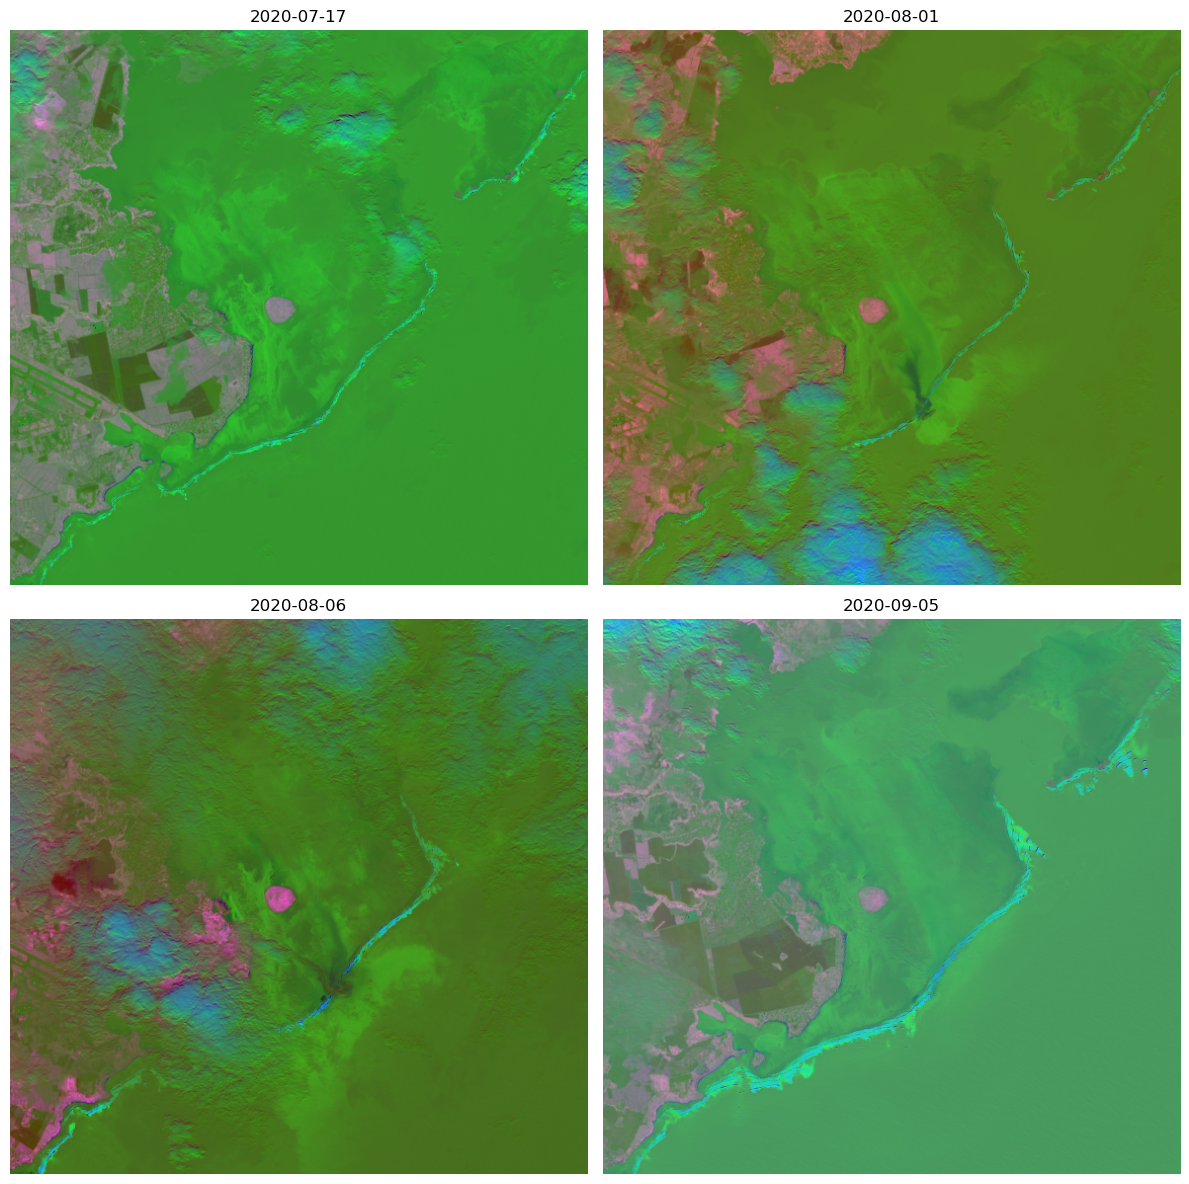

In [9]:
titles = ["2020-07-17", "2020-08-01", "2020-08-06", "2020-09-05"]
plot_osi_grid(datasets, titles)

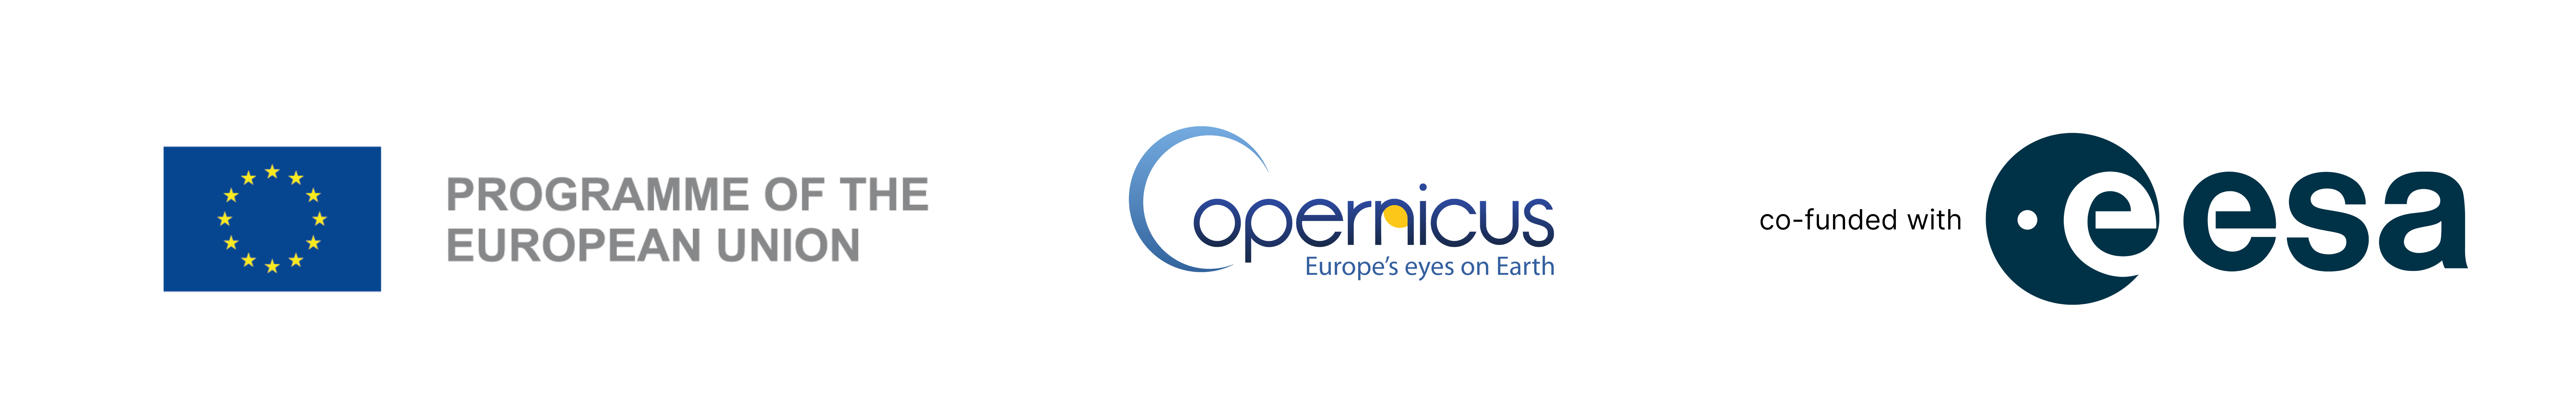